In [24]:
import GiovConfig as config
from GiovanniDataset import GiovanniDataset
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from osgeo import gdal
import cv2

In [18]:
def load_tif_image(tif_path):
    gdal_header = gdal.Open(str(tif_path))
    return gdal_header.ReadAsArray()

def apply_legal_amazon_mask(input_image: np.array, amazon_mask: np.array):
    ''' Apply Legal Amazon mask '''
    print('DEBUG apply_legal_amazon_mask')
    for i in range(input_image.shape[0]):
        # print(input_image.max(), input_image.min())
        input_image[i, :, :][amazon_mask == 2.0] = 2
        # print(input_image.max(), input_image.min())
    return input_image

def load_data(config):
    #! Loads data
    # load legal amazon limits
    am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)
    # load frames idx detail
    frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)
    # load frames deforestation area history
    deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
    deforestation["quarter_date"] = pd.to_datetime(deforestation["quarter_date"])

    # counties
    frames_county = pd.read_csv(config.TR_COUNTIES, index_col=0)
    counties_defor = pd.read_csv(config.TR_COUNTIES_DEFOR, index_col=0)

    # precipitations
    precip = pd.read_csv(config.TR_RAIN_AVG)
    precip["quarter_date"] = pd.to_datetime(precip["dt"])

    # terrain position index
    tpi = pd.read_csv(config.TR_TPI, skiprows=1)\
        .rename(columns={"Unnamed: 0": "frame_id"})

    # past scores
    past_scores = pd.read_csv(config.TR_PAST_SCORES)
    past_scores["variable"] = pd.to_datetime(past_scores["variable"])

    # night lights
    night_light = pd.read_csv(config.TR_NIGHT_LIGHT)
    night_light["dt"] = pd.to_datetime(night_light["dt"])
    
    return am_bounds, frames_idx, deforestation, frames_county, counties_defor, precip, tpi, past_scores, night_light

def create_grids(am_bounds, frames_idx, deforestation, frames_county, counties_defor, precip, tpi, past_scores, night_light):
    #! create limits history grid
    time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for t, dt in enumerate(config.TIME_STEPS):
        defor_area = (
            deforestation[
                deforestation["quarter_date"] == dt
            ].set_index("frame_id")["area"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        time_grid[t, :, :] = defor_area.values.reshape(time_grid[0, :, :].shape)
    
    # Population and density
    county_data = np.zeros((2, frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    county_data[0] = (
        frames_county.set_index("frame_id")["populacao"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).\
        values.reshape(county_data.shape[1:])

    county_data[1] = (
        frames_county.set_index("frame_id")["densidade"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).\
        values.reshape(county_data.shape[1:])
        
    # Deforestation
    frames_counties_defor = pd.merge(
        counties_defor,
        frames_county[["frame_id", "county_id"]],
        on="county_id",
        how="right"
    )
    frames_counties_defor["quarter_date"] = pd.to_datetime(frames_counties_defor["quarter_date"])

    counties_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for t, dt in tqdm(enumerate(config.TIME_STEPS)):
        defor_area = (
            frames_counties_defor[
                frames_counties_defor["quarter_date"] == dt
            ].set_index("frame_id")["area"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        counties_time_grid[t, :, :] = defor_area.values.reshape(counties_time_grid[0, :, :].shape)

    # Precipitations
    # create limits history grid
    precip_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for t, dt in tqdm(enumerate(config.TIME_STEPS)):
        precip_sum = (
            precip[
                precip["quarter_date"] == dt
            ].set_index("frame_id")["precipitation"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        precip_time_grid[t, :, :] = precip_sum.values.reshape(counties_time_grid[0, :, :].shape)

    # Terrain
    cols = ["mean", "min", "max", "std"]
    tpi_array = np.zeros((len(cols), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for icol, col in enumerate(cols):
        v = (
            tpi.set_index("frame_id")[col] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        tpi_array[icol, :, :] = v.values.reshape(tpi_array[0, :, :].shape)

    # Past Scores
    # create history grid for scores
    scores_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for t, dt in tqdm(enumerate(config.TIME_STEPS)):
        t_scores = (
            past_scores[
                past_scores["variable"] == dt
            ].set_index("frame_id")["value"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        scores_time_grid[t, :, :] = t_scores.values.reshape(scores_time_grid[0, :, :].shape)
        
    # Night Lights
    # create history grid for scores
    night_time_grid = np.zeros((2, len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
    for t, dt in tqdm(enumerate(config.TIME_STEPS)):
        avg_light = (
            night_light[
                night_light["dt"] == dt
            ].set_index("frame_id")["avg_light"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        night_time_grid[0, t, :, :] = avg_light.values.reshape(night_time_grid[0, 0, :, :].shape)
        
        max_light = (
            night_light[
                night_light["dt"] == dt
            ].set_index("frame_id")["max_light"] +\
            pd.Series(0, index=frames_idx.index)
        ).fillna(0).sort_index()
        night_time_grid[1, t, :, :] = max_light.values.reshape(night_time_grid[0, 0, :, :].shape)

    print(time_grid.shape, county_data.shape, night_time_grid.shape)
    return time_grid, county_data, counties_time_grid, precip_time_grid, tpi_array, scores_time_grid, night_time_grid

def plot_videos_side_by_side(video1, video2, video3, output_gif_path):
    # Determine the number of frames in the videos
    num_frames = min(video1.shape[0], video2.shape[0], video3.shape[0])

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Create colorbars for each subplot
    cbar1 = fig.colorbar(ax[0].imshow(video1[0], cmap='viridis'), ax=ax[0])
    cbar2 = fig.colorbar(ax[1].imshow(video2[0], cmap='viridis'), ax=ax[1])
    cbar3 = fig.colorbar(ax[2].imshow(video3[0], cmap='viridis'), ax=ax[2])

    # Set color bar labels
    cbar1.set_label('Probabilities')
    cbar2.set_label('Probabilities')
    cbar3.set_label('Class Argmax')

    # Function to update the plot for each frame
    def update(frame):
        # Get frames from both videos
        frame1 = video1[frame]
        frame2 = video2[frame]
        frame3 = video3[frame]

        # Plot frames side by side
        ax[0].imshow(frame1, cmap='viridis')
        ax[1].imshow(frame2, cmap='viridis')
        ax[2].imshow(frame3, cmap='viridis')
        
        # Add titles to each subplot
        ax[0].set_title(f'Probs Class 0 (No Def) - Frame {frame}')
        ax[1].set_title(f'Probs Class 1 (Def) - Frame {frame}')
        ax[2].set_title(f'Class Argmax - Frame {frame}')

    # # Create animation
    # animation = FuncAnimation(fig, update, frames=num_frames, interval=100)

    # # Save animation as gif
    # animation.save(output_gif_path, writer='imagemagick', fps=1, dpi=300)

    # Display the plot (optional)
    plt.show()

In [8]:
am_bounds, frames_idx, deforestation, frames_county, counties_defor, precip, tpi, past_scores, night_light = load_data(config)
time_grid, county_data, counties_time_grid, precip_time_grid, tpi_array, scores_time_grid, night_time_grid = create_grids(am_bounds, frames_idx, deforestation, frames_county, counties_defor, precip, tpi, past_scores, night_light)
test_time_idx = range(20,28)
test_data = time_grid[test_time_idx, :, :]

28it [00:04,  5.91it/s]
28it [00:03,  7.79it/s]
28it [00:00, 35.79it/s]
28it [00:06,  4.59it/s]

(28, 1002, 778) (2, 1002, 778) (2, 28, 1002, 778)


In [26]:
mask_path = '/home/thiago/AmazonDeforestation_Prediction/AmazonData/Dataset_Felipe/area.tif'
mask = load_tif_image(mask_path)
print(mask.shape)
mask[mask == 0.0] = 2.0
mask[mask == 1] = 0.0
print(test_data.shape)
# mask = np.resize(mask, [test_data.shape[1], test_data.shape[2]])
mask = cv2.resize(mask, [test_data.shape[2], test_data.shape[1]], interpolation=cv2.INTER_AREA)
print(mask.shape)
test_data = apply_legal_amazon_mask(test_data, mask)
print(test_data.max(), test_data.min())

(2332, 3004)
(8, 1002, 778)
(1002, 778)
DEBUG apply_legal_amazon_mask
2.0 0.0


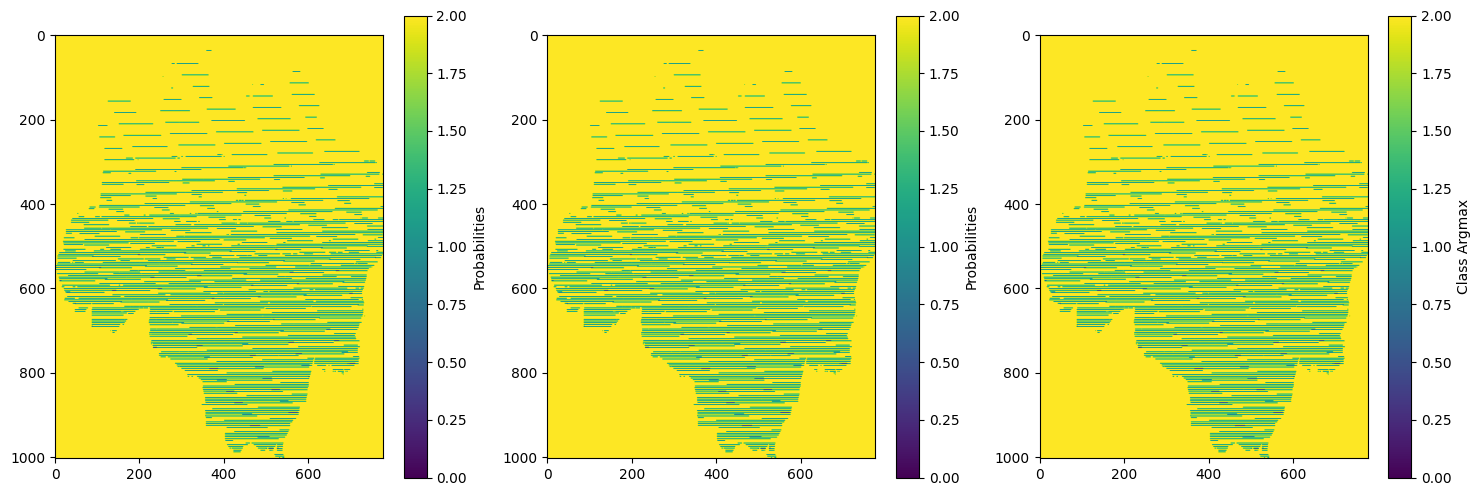

In [27]:
exp_path = Path('None')
plot_videos_side_by_side(test_data, test_data, test_data, exp_path / 'saved' / 'None.gif')